# House Price - Adcanced Regression Tchniques
![](https://storage.googleapis.com/kaggle-competitions/kaggle/5407/media/housesbanner.png)

# Load the House Price Data set from github

In [1]:
! wget -nc https://raw.githubusercontent.com/Jiansiyu/Classes/master/SYS6018_data%20mining/homework/homeworkproj/homework8/house-prices-advanced-regression-techniques/test.csv
! wget -nc https://raw.githubusercontent.com/Jiansiyu/Classes/master/SYS6018_data%20mining/homework/homeworkproj/homework8/house-prices-advanced-regression-techniques/train.csv
! wget -nc https://raw.githubusercontent.com/Jiansiyu/Classes/master/SYS6018_data%20mining/homework/homeworkproj/homework8/house-prices-advanced-regression-techniques/sample_submission.csv

File ‘test.csv’ already there; not retrieving.

File ‘train.csv’ already there; not retrieving.

File ‘sample_submission.csv’ already there; not retrieving.



# Load the dataset to the 

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression,Lasso,Ridge,LassoCV
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import  skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
%matplotlib inline

In [3]:
train = pd.read_csv("./train.csv")
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Clean The Dataset

## data clean process

In [4]:
typoTable = {"Exterior2nd":[{"Brk Cmn":"BrkComm"},{"Wd Shng":"Wd Sdng"},{"CmentBd":"CemntBd"}]
             }

def typoCorrection(df):
    '''
    used correct the typos in the feature columnn according to the typotable
    :param df:
    :return:
    '''
    for colName, replaceTerm in typoTable.items():
        for replaceKey in replaceTerm:
          df[colName] = df[colName].replace(replaceKey)
    return df

def fillnumerical(df):
    '''

    :param df:
    :return:
    '''

    # size = len(df)
    # for colname in df:
    #     nanSum = df[colname].isnull().sum()
    #     col_type = df[colname].dtypes == "object"
    #     if nanSum > 0 and not col_type:
    #       if nanSum/size < 0.85:
    #         df[colname].fillna( df[colname].median(), inplace=True)
    #       else:
    #         df[colname].fillna( df[colname].mean(), inplace=True)
    return df


def fillCat(features):
    '''

    :param features:
    :return:
    '''
    features['Functional'] = features['Functional'].fillna('Typ')
    features['Electrical'] = features['Electrical'].fillna("SBrkr")
    features['KitchenQual'] = features['KitchenQual'].fillna("TA")
    features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
    features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

    features["PoolQC"] = features["PoolQC"].fillna("None")

    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        features[col] = features[col].fillna(0)
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        features[col] = features[col].fillna('None')
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        features[col] = features[col].fillna('None')

    features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

    objects = []
    for i in features.columns:
        if features[i].dtype == object:
            objects.append(i)

    features.update(features[objects].fillna('None'))

    features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # Filling in the rest of the NA's

    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numerics = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numerics.append(i)
    features.update(features[numerics].fillna(0))

    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numerics2 = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numerics2.append(i)

    skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

    high_skew = skew_features[skew_features > 0.5]
    skew_index = high_skew.index

    for i in skew_index:
        features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

    return features

def featureGenerator(features):
    '''
    :param df:
    :return:
    : dis : generate new features
    '''
    #features = features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

    features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']

    features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

    features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                     features['1stFlrSF'] + features['2ndFlrSF'])

    features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                                   features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

    features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                                  features['EnclosedPorch'] + features['ScreenPorch'] +
                                  features['WoodDeckSF'])

    # simplified features
    features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    return features

def simplifyer(df):

    return df

def featurize(features):
    '''
    Convert some number feature to class feature
    :param features:
    :return:  the transformed new dataframe
    '''
    features['MSSubClass'] = features['MSSubClass'].astype(str)
    features['YrSold'] = features['YrSold'].astype(str)
    features['MoSold'] = features['MoSold'].astype(str)
    return features
def dropFeatues(df):
    '''

    :param df:
    :return:
    '''
    return  df

def dummirize(df):
    dummied = pd.get_dummies(df).reset_index(drop=True)
    return dummied


def cleanData(df):
    '''
    :param df:
    :return:
    '''
    # apply typo correction
    df = typoCorrection(df)
    df = featurize(df)
    # df = fillnumerical(df)
    df = fillCat(df)
    df = featureGenerator(df)
    df = dropFeatues(df)
    df = dummirize(df)
    return df

In [5]:
def Load_DataSet():
    baseDir = "./"
    train_name = "train.csv"
    test_name  = "test.csv"

    train_file = os.path.join(baseDir, train_name)
    test_file   = os.path.join(baseDir,test_name)

    train_pd = pd.read_csv(train_file,index_col="Id")
    test_pd  = pd.read_csv(test_file,index_col= "Id")
    train_pd = train_pd[train_pd.GrLivArea < 4500]
    train_pd.reset_index(drop=True, inplace=True)
    train_pd["SalePrice"] = np.log1p(train_pd["SalePrice"])

    train_feature = train_pd.drop(["SalePrice"],axis = 1)
    trainPrice = train_pd.SalePrice.reset_index(drop = True)
    test_feature = test_pd

    print(train_feature.shape, test_feature.shape)
    # merge the data together for pre-processing
    df = pd.concat([train_feature,test_feature]).reset_index(drop = True)
    #TODO preprocess the dataset

    df = cleanData(df)

    train_pd = df.iloc[:len(train_pd),:]
    test_pd  = df.iloc[len(train_pd):, :]
    # train_pd= df.loc[train_pd.index, :]
    # test_pd = df.loc[test_pd.index, :]

    # splite the pre-preocessed dataset
    return train_pd, trainPrice, test_pd

# Mutal Information

In [6]:
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

(1458, 79) (1459, 79)


/home/newdriver/Storage/HomeDir/Classes/SYS6018_data mining/homework/homeworkproj/homework8/venv/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/newdriver/Storage/HomeDir/Classes/SYS6018_data mining/homework/homeworkproj/homework8/venv/lib/python3.8/site-packages/scipy/stats/stats.py:3943: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


['OverallQual',
 'TotalSF',
 'GrLivArea',
 'YrBltAndRemod',
 'YearBuilt',
 'Total_sqr_footage',
 'Total_Bathrooms',
 'GarageCars',
 'TotalBsmtSF',
 'GarageArea',
 '1stFlrSF',
 'YearRemodAdd',
 'ExterQual_TA',
 'FullBath',
 'GarageYrBlt',
 'TotRmsAbvGrd',
 'KitchenQual_TA',
 'ExterQual_Gd',
 'LotFrontage',
 'LotArea',
 '2ndFlrSF',
 'KitchenQual_Gd',
 'Foundation_PConc',
 'BsmtQual_TA',
 'Fireplaces',
 'FireplaceQu_None',
 'hasfireplace',
 'BsmtQual_Gd',
 'Total_porch_sf',
 'OpenPorchSF',
 'BsmtFinSF1',
 'GarageFinish_Unf',
 'HeatingQC_Ex',
 'BsmtUnfSF',
 'GarageType_Attchd',
 'BsmtQual_Ex',
 'MSSubClass_60',
 'GarageFinish_Fin',
 'MasVnrArea',
 'OverallCond',
 'BsmtFinType1_GLQ',
 'Foundation_CBlock',
 'Exterior2nd_VinylSd',
 'GarageType_Detchd',
 'WoodDeckSF',
 'KitchenQual_Ex',
 'HeatingQC_TA',
 'LotShape_Reg',
 'GarageFinish_RFn',
 'Exterior1st_VinylSd']

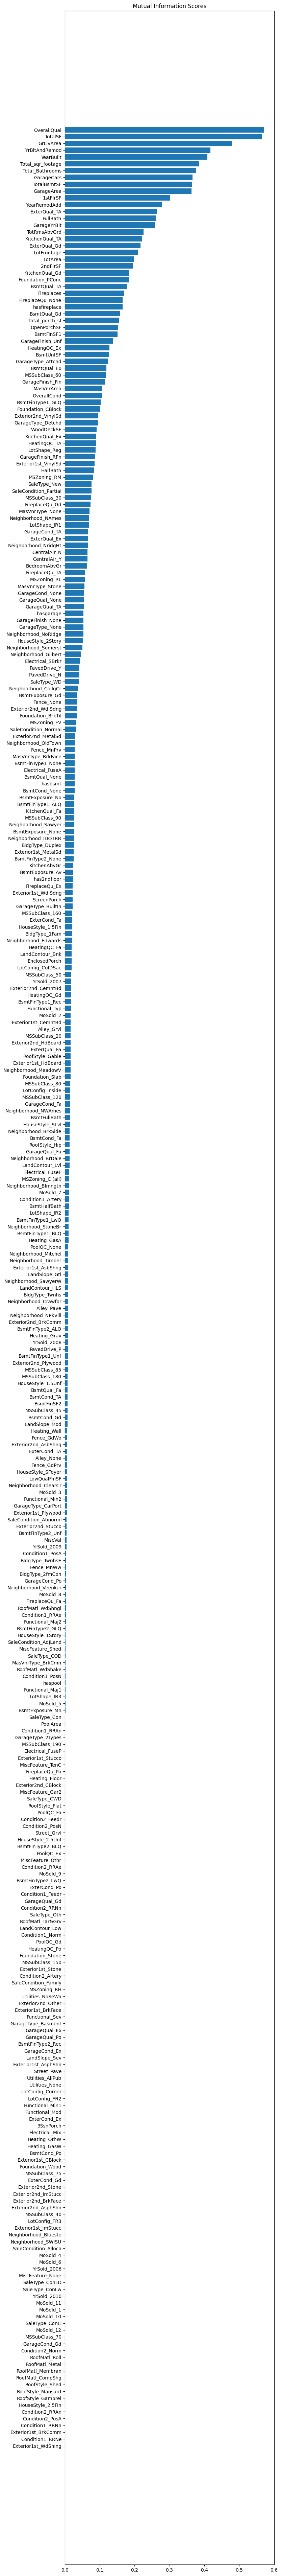

In [7]:
train,trainPrice, test = Load_DataSet()
train.head()
X = train.copy()
y = trainPrice
test
#label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()
#discrete features should have integer dtypes
discrete_features = X.dtypes == int

mi_scores = make_mi_scores(X, y, discrete_features)
# mi_scores
plt.figure(dpi = 100, figsize = (8,100))
plot_mi_scores(mi_scores)
feature50 = mi_scores.keys()[:50].tolist()
feature50

# Training process

## Prepare the Data Set used for the training and test

In [8]:
import warnings
warnings.filterwarnings('ignore')

## overwrite the previous test set
X,y, test = Load_DataSet()

X = X[feature50]
test = test[feature50]
print("Train Feature : {}, price {}, test feature {}".format(X.shape, y.shape, test.shape))

for item in X.columns:
    print(item)

outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
# overfit.append('MSZoning_C (all)')

X = X.drop(overfit, axis=1).copy()

X_sub = test.drop(overfit, axis=1).copy()

print('X', X.shape, 'y', y.shape, 'X_sub', X_sub.shape)

(1458, 79) (1459, 79)
Train Feature : (1458, 50), price (1458,), test feature (1459, 50)
OverallQual
TotalSF
GrLivArea
YrBltAndRemod
YearBuilt
Total_sqr_footage
Total_Bathrooms
GarageCars
TotalBsmtSF
GarageArea
1stFlrSF
YearRemodAdd
ExterQual_TA
FullBath
GarageYrBlt
TotRmsAbvGrd
KitchenQual_TA
ExterQual_Gd
LotFrontage
LotArea
2ndFlrSF
KitchenQual_Gd
Foundation_PConc
BsmtQual_TA
Fireplaces
FireplaceQu_None
hasfireplace
BsmtQual_Gd
Total_porch_sf
OpenPorchSF
BsmtFinSF1
GarageFinish_Unf
HeatingQC_Ex
BsmtUnfSF
GarageType_Attchd
BsmtQual_Ex
MSSubClass_60
GarageFinish_Fin
MasVnrArea
OverallCond
BsmtFinType1_GLQ
Foundation_CBlock
Exterior2nd_VinylSd
GarageType_Detchd
WoodDeckSF
KitchenQual_Ex
HeatingQC_TA
LotShape_Reg
GarageFinish_RFn
Exterior1st_VinylSd
X (1453, 50) y (1453,) X_sub (1459, 50)


## start the pipline and training the model

### predefine the constant

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import  KFold, cross_val_score
from  sklearn.linear_model import  ElasticNetCV, LassoCV, RidgeCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
from datetime import  datetime


print('START ML', datetime.now(), )

kfolds = KFold(n_splits=10, shuffle=True, random_state=42)


# rmsle
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


# build our model scoring function
def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y,
                                    scoring="neg_mean_squared_error",
                                    cv=kfolds))
    return (rmse)


# setup models
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

ridge = make_pipeline(RobustScaler(),
                      RidgeCV(alphas=alphas_alt, cv=kfolds,))

lasso = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, alphas=alphas2,
                              random_state=42, cv=kfolds))

elasticnet = make_pipeline(RobustScaler(),
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas,
                                        cv=kfolds, random_state=42, l1_ratio=e_l1ratio))

svr = make_pipeline(RobustScaler(),
                      SVR(C= 20, epsilon= 0.008, gamma=0.0003,))


gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state =42)


lightgbm = LGBMRegressor(objective='regression',
                                       num_leaves=4,
                                       learning_rate=0.01,
                                       n_estimators=5000,
                                       max_bin=200,
                                       bagging_fraction=0.75,
                                       bagging_freq=5,
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       #min_data_in_leaf=2,
                                       #min_sum_hessian_in_leaf=11
                                       )


xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006, random_state=42)

# stack
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet,
                                            gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)


print('TEST score on CV')

score = cv_rmse(ridge)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(elasticnet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(svr)
print("SVR score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )


# # build our model scoring function
# def cv_rmse(model, X=X):
#     rmse = np.sqrt(-cross_val_score(model, X, y,
#                                     scoring="neg_mean_squared_error",
#                                     cv=kfolds))
#     return (rmse)
#
# # setup models
# alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
# alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
# e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
# e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
#
# kfolds = KFold(n_splits=10, shuffle=True, random_state= 10)
#
# ridgeReg = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt,cv = kfolds,))
#
# lassoReg = make_pipeline(RobustScaler(),LassoCV(max_iter=1e7, alphas=alphas2, random_state = 10, cv = kfolds))
#
# elasticNet = make_pipeline(RobustScaler(),
#                            ElasticNetCV(max_iter= 1e7, alphas=e_alphas,
#                                         cv = kfolds, random_state=10, l1_ratio=e_l1ratio)
#                            )
#
# svr = make_pipeline(RobustScaler(),
#                       SVR(C= 20, epsilon= 0.008, gamma=0.0003,))
#
#
# gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
#                                    max_depth=4, max_features='sqrt',
#                                    min_samples_leaf=15, min_samples_split=10,
#                                    loss='huber', random_state =42)
#
# lightgbm = LGBMRegressor(objective='regression',
#                                        num_leaves=4,
#                                        learning_rate=0.01,
#                                        n_estimators=5000,
#                                        max_bin=200,
#                                        bagging_fraction=0.75,
#                                        bagging_freq=5,
#                                        bagging_seed=7,
#                                        feature_fraction=0.2,
#                                        feature_fraction_seed=7,
#                                        verbose=-1,
#                                        #min_data_in_leaf=2,
#                                        #min_sum_hessian_in_leaf=11
#                                        )
#
#
# xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
#                                      max_depth=3, min_child_weight=0,
#                                      gamma=0, subsample=0.7,
#                                      colsample_bytree=0.7,
#                                      objective='reg:linear', nthread=-1,
#                                      scale_pos_weight=1, seed=27,
#                                      reg_alpha=0.00006, random_state=10)
#
# stack_gen = StackingCVRegressor(regressors=(ridgeReg, lassoReg, elasticNet,
#                                             gbr, xgboost, lightgbm),
#                                 meta_regressor=xgboost,
#                                 use_features_in_secondary=True)
#
#
# score = cv_rmse(ridgeReg)
# print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# #
# score = cv_rmse(lassoReg)
# print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
#
# score = cv_rmse(elasticNet)
# print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
#

START ML 2021-04-19 20:08:58.071297
TEST score on CV
Kernel Ridge score: 0.1145 (0.0106)
 2021-04-19 20:09:05.647718
Lasso score: 0.1145 (0.0106)
 2021-04-19 20:09:06.703794
ElasticNet score: 0.1145 (0.0106)
 2021-04-19 20:09:10.385726
SVR score: 0.1147 (0.0107)
 2021-04-19 20:09:11.525688


In [10]:
score = cv_rmse(svr)
print("SVR score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(lightgbm)
print("Lightgbm score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()) )

score = cv_rmse(gbr)
print("GradientBoosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(xgboost)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

SVR score: 0.1147 (0.0107)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction 

In [11]:
# rmsle
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


print('START Fit')
print(datetime.now(), 'StackingCVRegressor')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))
print(datetime.now(), 'elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)
print(datetime.now(), 'lasso')
lasso_model_full_data = lasso.fit(X, y)
print(datetime.now(), 'ridge')
ridge_model_full_data = ridge.fit(X, y)
print(datetime.now(), 'svr')
svr_model_full_data = svr.fit(X, y)
print(datetime.now(), 'GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)
print(datetime.now(), 'xgboost')
xgb_model_full_data = xgboost.fit(X, y)
print(datetime.now(), 'lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

START Fit
2021-04-19 20:12:48.369385 StackingCVRegressor
[20:13:48] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:51] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:55] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:59] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:14:04] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.

In [12]:
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.05 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.3 * stack_gen_model.predict(np.array(X))))

print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))

RMSLE score on train data:
0.0681261653267545


In [13]:
X.head()

,OverallQual,TotalSF,GrLivArea,YrBltAndRemod,YearBuilt,Total_sqr_footage,Total_Bathrooms,GarageCars,TotalBsmtSF,GarageArea,...,BsmtFinType1_GLQ,Foundation_CBlock,Exterior2nd_VinylSd,GarageType_Detchd,WoodDeckSF,KitchenQual_Ex,HeatingQC_TA,LotShape_Reg,GarageFinish_RFn,Exterior1st_VinylSd
0,7,1454.079522,8.353543,4006,2003,1175.708875,3.527858,2.0,422.488510,548.0,...,1,0,1,0,0.000000,0,0,1,1,1
1,6,600.123169,7.974693,3952,1976,187.954176,2.355448,2.0,593.888179,460.0,...,0,1,0,0,56.184223,0,0,1,1,0
2,7,1496.595112,8.408064,4003,2001,1156.956429,3.527858,2.0,450.079716,608.0,...,1,0,1,0,0.000000,0,0,0,1,1
3,7,1289.359693,8.358662,3885,1915,972.300440,1.993440,3.0,378.854568,642.0,...,0,0,0,1,0.000000,0,0,0,0,0
4,8,1824.496011,8.669321,4000,2000,1415.810685,3.527858,3.0,545.309927,836.0,...,1,0,1,0,42.245702,0,0,0,1,1


In [14]:
test.head()

subRes = test.copy()
subRes['SalePrice'] = np.expm1(blend_models_predict(X_sub))
subRes = subRes[['SalePrice']]
#subRes.index.name = "Id"
subRes#.to_csv("submit.csv")

,SalePrice
1458,124641.252819
1459,163772.120905
1460,186877.726119
1461,199680.047169
1462,184731.216103
...,...
2912,84831.938529
2913,86850.214743
2914,183682.623998
2915,115288.972111


In [15]:
submission = pd.read_csv("./sample_submission.csv")
submission.iloc[:,1] = np.floor(np.expm1(blend_models_predict(X_sub)))

submission.to_csv("submission_v6.csv",index=False)